#**Using pure TensorFlow tensor datastructure to build a 3 layer neural network**

In [1]:
import tensorflow as tf 
import numpy
import math

In [15]:
#generating 3-d non linear data

n_samples = 200
d = 3
x = tf.random.normal([n_samples, d], -1, 1, tf.float32, seed=1) #casting to float32 

weights_true = tf.cast(tf.constant([[5, 1, 6], [1, 6, 1]]), tf.float32)
bias_true = tf.cast(tf.constant([1, 1]), tf.float32)

y_true = tf.matmul((x ** 2), weights_true, transpose_b=True) + tf.matmul(x, weights_true, transpose_b=True) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (200, 3), weights: (2, 3), bias: (2,), y: (200, 2)


###Plotting the data

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_3d(x, y, y_pred=None):
  X_embedded = TSNE(n_components=2).fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y, label='underlying function') 
  if y_pred is not None:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y_pred, label='our function')
  plt.legend()

###Plotting both the labels in y_true

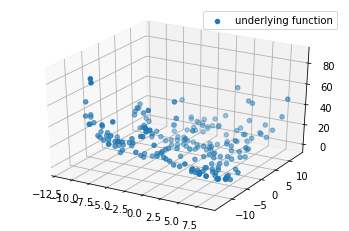

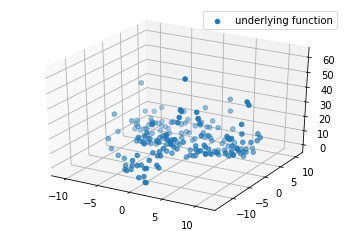

In [17]:
plot_3d(x, y_true[:, 0])
plot_3d(x, y_true[:, 1])

##Specifying all the necessary functions and defining the model with TensorFlow

In [18]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return tf.reduce_mean((y_pred - y_true) ** 2)
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

###Linear Layer

In [23]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = tf.Variable(tf.random.normal(shape = (input_dim, num_hidden)))
    self.bias = tf.zeros(shape=(num_hidden))

  def __call__(self, x):
    self.x = x
    output = tf.matmul(x, self.weights) + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = tf.matmul(self.x, gradient, transpose_a=True)
    self.bias_gradient = tf.reduce_sum(gradient, axis=0)
    self.x_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.x_gradient
  
  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

###Defining ReLU

In [27]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = tf.clip_by_value(self.input_, 0, math.inf)
    return self.output
  
  def backward(self, output_gradient):
    self.input_gradient = tf.cast((self.input_ > 0), tf.float32) * output_gradient
    return self.input_gradient

###Defining the model class

In [28]:
#Building a 3 Layer Neural Network model. Choosing 10 neurons as the hidden layer neurons. Output is 2

class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.linear2 = Linear(num_hidden, 10)
    self.relu2 = Relu()
    self.linear3 = Linear(10, 2)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r1= self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):
    linear3_gradient = self.linear3.backward(output_gradient)
    relu2_gradient = self.relu2.backward(linear3_gradient)
    linear2_gradient = self.linear2.backward(relu2_gradient)
    relu1_gradient = self.relu1.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu1_gradient)
    return linear1_gradient
  
  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

###Defining the fit method and traning the model

In [37]:
from typing import Callable

def fit(x, y, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

loss = MSE()
model = Model(d, 10)

fit(x, y_true, model=model, loss=loss, lr=0.03, num_epochs=100)

Epoch 0, loss 217.91966247558594
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 1, loss 13425.90625
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 2, loss 34335.19921875
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 3, loss 686.4025268554688
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 4, loss 246.4239044189453
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 5, loss 222.21456909179688
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 6, loss 211.69268798828125
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 7, loss 207.50013732910156
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 8, loss 228.24632263183594
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 9, loss 219.0216064453125
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 10, loss 210.1179656982422
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 11, loss 201.21112060546875
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 12, loss 180.2977752685547
MSE backward (200, 2) (200, 2) (200, 2)
Epoch 13, loss 170.9585418701172
MSE backward (200, 2) (200, 2) 

###Plotting both the labels in y_true and y_pred

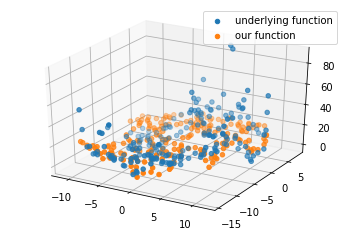

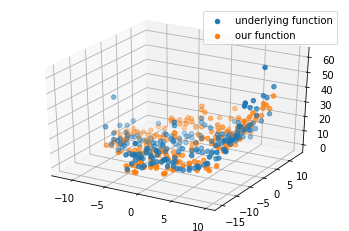

In [38]:
plot_3d(x, y_true[:, 0], model(x)[:, 0])
plot_3d(x, y_true[:, 1], model(x)[:, 1])